# AutoEncoder

Building an Autoencoder roughly based on the U-Net.

In [1]:
import numpy as np
np.random.seed(1993)
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc
import datetime


## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

In [2]:
X = np.load("/scratch2/ttoebro/data/X_test_subset.npy")

In [3]:
X.shape

(1000, 256, 256, 1)

 Normalize data

In [4]:
Y = np.load('/scratch2/ttoebro/data/Y_test_subset.npy')

In [5]:
Y.shape

(1000, 256, 256, 1)

clean up the mess

In [6]:
gc.collect()

17

In [7]:
Y.shape

(1000, 256, 256, 1)

In [8]:
def conv_layer(tensor_in, name_layer, is_training):
    x = tf.layers.conv2d(
    inputs = tensor_in,
    filters = 64,
    kernel_size = [3, 3],
    padding = "same",
    activation= None,
    name = name_layer)
    
    x = tf.layers.batch_normalization(x, name = name_layer + "_bn",
                             center=True, 
                             scale=True, 
                             training=is_training)
    
    return tf.nn.relu(x, name = name_layer + "_relu")

# Create and train CNN

In [9]:
def AutoEncoder_model(features, labels, mode):
	# Input Layer
	input_layer = features['x']

	# Convolutional layer #1     
	conv1 = tf.layers.conv2d(
	inputs = input_layer,
	filters = 64,
	kernel_size = 3,
	padding = "same",
	activation= tf.nn.relu,
	name = "Conv_1")
	is_training_mode = (mode == tf.estimator.ModeKeys.TRAIN)

	# 18 of the middle layers with Convolution, batch normalization and afterwards ReLu
	conv2 = conv_layer(conv1, "conv2", is_training = is_training_mode)
	conv3 = conv_layer(conv2, "conv3", is_training = is_training_mode)
	conv4 = conv_layer(conv3, "conv4", is_training = is_training_mode)
	conv5 = conv_layer(conv4, "conv5", is_training = is_training_mode)
	conv6 = conv_layer(conv5, "conv6", is_training = is_training_mode)
	conv7 = conv_layer(conv6, "conv7", is_training = is_training_mode)
	conv8 = conv_layer(conv7, "conv8", is_training = is_training_mode)
	conv9 = conv_layer(conv8, "conv9", is_training = is_training_mode)
	conv10 = conv_layer(conv9, "conv10", is_training = is_training_mode)
	conv11 = conv_layer(conv10, "conv11", is_training = is_training_mode)
	conv12 = conv_layer(conv11, "conv12", is_training = is_training_mode)
	conv13 = conv_layer(conv12, "conv13", is_training = is_training_mode)
	conv14 = conv_layer(conv13, "conv14", is_training = is_training_mode)
	conv15 = conv_layer(conv14, "conv15", is_training = is_training_mode)
	conv16 = conv_layer(conv15, "conv16", is_training = is_training_mode)
	conv17 = conv_layer(conv16, "conv17", is_training = is_training_mode)
	conv18 = conv_layer(conv17, "conv18", is_training = is_training_mode)
	conv19 = conv_layer(conv18, "conv19", is_training = is_training_mode)

	# final 
	final_layer = tf.layers.conv2d(
	inputs = conv19,
	filters = 1,
	kernel_size = [1, 1],
	padding = "same",
	activation = None,
	name = "final_layer") + input_layer


	if not (mode == tf.estimator.ModeKeys.PREDICT):
	# Output all learnable variables for tensorboard
		for var in tf.trainable_variables():
			name = var.name
			name = name.replace(':', '_')
			tf.summary.histogram(name, var)
			merged_summary = tf.summary.merge_all()

	if mode == tf.estimator.ModeKeys.TRAIN:
		tf.summary.image("Input_Image", input_layer, max_outputs = 1)
		tf.summary.image("Output_Image", final_layer, max_outputs = 1)
		tf.summary.image("True_Image", labels,  max_outputs = 1)
		tf.summary.histogram("Summary_final_layer", final_layer)
		tf.summary.histogram("Summary_labels", labels)

	# Give output in prediction mode
	if mode == tf.estimator.ModeKeys.PREDICT:
		return tf.estimator.EstimatorSpec(mode = mode, predictions=final_layer)


	# Calculate Loss (for both Train and EVAL modes)
	# See that the residual learning is implemented here.
	loss = tf.losses.mean_squared_error(labels = labels , predictions = final_layer)
	tf.summary.scalar("Value_Loss_Function", loss)

	# Configure Learning when training.
	if mode == tf.estimator.ModeKeys.TRAIN:
		update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
		with tf.control_dependencies(update_ops):
			original_optimizer = tf.train.AdamOptimizer(learning_rate =  0.015)
			optimizer = tf.contrib.estimator.clip_gradients_by_norm(original_optimizer, clip_norm=5.0)
			train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
			return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

Load train and test data

Create the estimator

In [23]:
runconf = tf.estimator.RunConfig(save_summary_steps=5, log_step_count_steps = 1)

In [24]:
AutoEncoder = tf.estimator.Estimator(config=runconf,
    model_fn=AutoEncoder_model, model_dir="/home/cloud/model/DnCNN_V2_run3"
    )

INFO:tensorflow:Using config: {'_model_dir': '/home/cloud/model/DnCNN_V2_run3', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 1, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0bfc1be358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


This is an original image. What does our network predict?

In [25]:
n_images = 150

In [26]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X[0:(n_images + 1),:,:,:]},
    y=Y[0:(n_images + 1),:,:,:],
    batch_size = 1,
    shuffle=False)
predict_results = AutoEncoder.predict(input_fn=predict_input_fn)

In [27]:
out = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/cloud/model/DnCNN_V2_run3/model.ckpt-811977
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [28]:
cur_pic = np.random.randint(0, n_images)

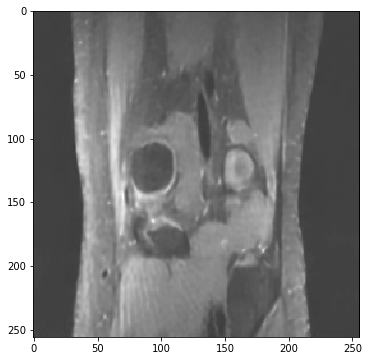

In [29]:
plt.figure(figsize = (6,6))
plt.imshow(out[cur_pic][:,:,0], cmap='gray')

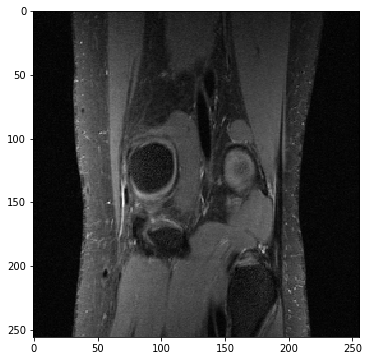

In [30]:
plt.figure(figsize = (6,6))
plt.imshow(Y[cur_pic,:,:,0], cmap='gray' )

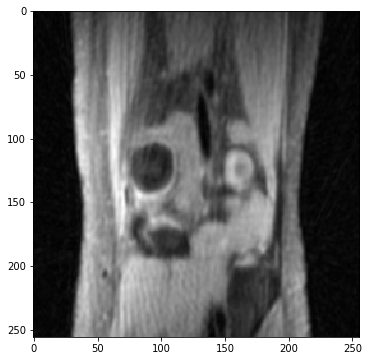

In [31]:
plt.figure(figsize = (6,6))
plt.imshow(X[cur_pic,:,:,0], cmap='gray' )